In [122]:
import glob
import random
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim import corpora, models
from tqdm import tqdm
import numpy as np

stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in simple_preprocess(text, min_len = 4):
        if token not in STOPWORDS:
            result.append(lemmatize_stemming(token))
    return result

cat_list = glob.glob ("categories/*")
cat_size = len(cat_list)

random.seed(0)
cat_names = []
cat_text = []
sample_size = min(30, cat_size)
cat_sample = sorted(random.sample(range(cat_size), sample_size))

count = 0
for i in cat_sample:
    cat_names.append(cat_list[i].split('/')[-1][:-4].replace("_"," "))
    with open(cat_list[i]) as f:
        cat_text.append(f.read().replace("\n", "").replace("\r",""))

processed_docs = [preprocess(text) for text in tqdm(cat_text)]
dictionary = corpora.Dictionary(processed_docs)
print("Before prunn:%d"%(len(dictionary)))
dictionary.filter_extremes(no_above=0.5)
print("After prunn:%d"%(len(dictionary)))
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

100%|██████████| 30/30 [07:08<00:00,  7.44s/it]


Before prunn:104491
After prunn:12748


In [141]:
v= dict(corpus[0])
1 in v

True

In [143]:
import math

def cos_dist(a, b):
    d = 0
    norm_a = 0
    norm_b = 0
    denom = 0
    for a_i, a_v in a:
        norm_a += a_v * a_v
        for b_i, b_v in b:
            norm_b += b_v * b_v
            if a_i == b_i:
                denom += a_v * b_v
    
    norm_a = math.sqrt(norm_a)
    norm_b = math.sqrt(norm_b)
    
    return denom / (norm_a * norm_b)

In [147]:
import numpy as np
np.zeros([3,3])

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
import numpy as np
sim = np.zeros([len(corpus), len(corpus)])

for i in range(0, len(corpus) - 1):
    for j in range(i + 1, len(corpus)):
        sim[i][j] = cos_dist(corpus[i], corpus[j])

In [123]:
import pandas as pd
import seaborn as sns; 
import matplotlib.pyplot as plt

data = pd.read_csv("cuisine_sim_matrix.csv", header=None)
data.index = cat_names
data.columns = cat_names

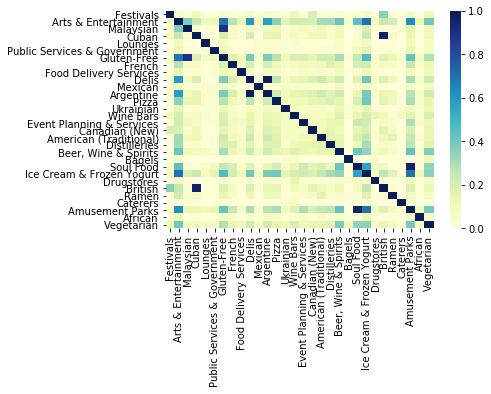

In [124]:
ax = sns.heatmap(data,cmap="YlGnBu", xticklabels=True, yticklabels=True)
plt.show()

In [128]:
corpus[29]

[(0, 1),
 (4, 1),
 (5, 2),
 (6, 1),
 (7, 1),
 (8, 2),
 (10, 1),
 (13, 1),
 (15, 1),
 (16, 3),
 (18, 1),
 (20, 5),
 (26, 29),
 (29, 4),
 (30, 1),
 (31, 5),
 (32, 1),
 (34, 4),
 (35, 1),
 (38, 6),
 (42, 1),
 (43, 5),
 (46, 1),
 (47, 1),
 (49, 4),
 (51, 1),
 (52, 2),
 (53, 1),
 (54, 4),
 (56, 3),
 (57, 1),
 (59, 2),
 (60, 2),
 (61, 1),
 (62, 1),
 (64, 2),
 (65, 8),
 (67, 1),
 (68, 15),
 (70, 7),
 (74, 2),
 (75, 2),
 (78, 1),
 (79, 1),
 (80, 3),
 (82, 19),
 (84, 1),
 (85, 1),
 (87, 2),
 (91, 3),
 (92, 3),
 (94, 1),
 (95, 1),
 (97, 2),
 (103, 2),
 (104, 3),
 (108, 1),
 (110, 8),
 (111, 4),
 (116, 1),
 (117, 4),
 (118, 3),
 (119, 1),
 (120, 5),
 (124, 2),
 (125, 2),
 (126, 2),
 (127, 5),
 (129, 1),
 (130, 1),
 (132, 3),
 (133, 3),
 (134, 1),
 (137, 4),
 (139, 2),
 (140, 1),
 (141, 1),
 (144, 1),
 (145, 2),
 (146, 1),
 (147, 2),
 (148, 1),
 (149, 2),
 (151, 1),
 (152, 1),
 (154, 1),
 (157, 3),
 (158, 3),
 (159, 14),
 (162, 1),
 (166, 2),
 (170, 2),
 (172, 5),
 (173, 1),
 (174, 2),
 (180, 2),


In [108]:
len(d)

0